# PCR Design and Simulation for KRAS Detection (chr12:25209843 A>G)

By Luis Aguilera. November 18, 2025

This notebook designs allele-specific PCR primers to detect the KRAS mutation and simulates PCR amplification for both wildtype and mutant sequences.

__

## Import Libraries

In [1]:
import requests
from pathlib import Path
#import re
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqUtils import MeltingTemp as mt
from Bio.SeqUtils import gc_fraction
import matplotlib.pyplot as plt
from pypcrtool.pcr import InSilicoPCR
from pcr_visualization import PCRVisualization


## Setup Working Directory

In [2]:
working_directory = Path.cwd()
output_directory = working_directory / "pcr_design_output"
output_directory.mkdir(exist_ok=True)
print(f"Output directory: {output_directory}")

Output directory: /Users/nzlab-la/Desktop/circulating_tumor_DNA_analysis/dev/pcr_design_output


## Define Target Mutation

In [3]:
# KRAS G12D mutation information
chromosome = "12"
mutation_position = 25209843  # GRCh38 coordinates
reference_allele = "A"
variant_allele = "G"
mutation_name = "KRAS_mut"
codon_position = 12  # This is codon 12 in KRAS

print(f"Target Mutation: {mutation_name}")
print(f"Location: chr{chromosome}:{mutation_position}")
print(f"Change: {reference_allele}>{variant_allele}")


Target Mutation: KRAS_mut
Location: chr12:25209843
Change: A>G


## Download KRAS Gene Sequence from Ensembl

In [4]:
def download_sequence_from_ensembl(chromosome, start_position, end_position, strand=1):
    """
    Download genomic sequence from Ensembl REST API.
    Input: chromosome (str), start_position (int), end_position (int), strand (int)
    Output: str - DNA sequence
    """
    ensembl_url = f"https://rest.ensembl.org/sequence/region/human/{chromosome}:{start_position}..{end_position}:{strand}"
    headers = {"Content-Type": "text/plain"}
    print(f"Downloading sequence from Ensembl...")
    print(f"Region: chr{chromosome}:{start_position}-{end_position}")
    response = requests.get(ensembl_url, headers=headers)
    if not response.ok:
        raise ValueError(f"Failed to download sequence: {response.status_code}")
    sequence = response.text.strip()
    print(f"Downloaded {len(sequence)} bp")
    return sequence

# Download 500 bp around the mutation (250 bp upstream and downstream)
region_padding = 250
region_start = mutation_position - region_padding
region_end = mutation_position + region_padding

reference_sequence = download_sequence_from_ensembl(chromosome, region_start, region_end, strand=1)
print(f"\nSequence length: {len(reference_sequence)} bp")

Region: chr12:25209593-25210093
Downloaded 501 bp

Sequence length: 501 bp


## Verify Mutation Position and Create Variant Sequence

In [5]:
# The mutation should be at the center of our downloaded sequence
mutation_index = region_padding  # Index in our sequence (0-based)

# Verify the reference allele matches
print(f"Reference allele at position: {reference_sequence[mutation_index]}")
print(f"Expected reference allele: {reference_allele}")

if reference_sequence[mutation_index].upper() == reference_allele:
    print(" Reference allele matches!")
else:
    print(" WARNING: Reference allele mismatch!")

# Create variant sequence by introducing the mutation
variant_sequence = (
    reference_sequence[:mutation_index] + 
    variant_allele + 
    reference_sequence[mutation_index + 1:]
)

print(f"\nWildtype (WT) sequence around mutation:")
print(f"...{reference_sequence[mutation_index-20:mutation_index+21]}...")
print(f"                    ↑ position {mutation_position}")

print(f"\nMutant sequence around mutation:")
print(f"...{variant_sequence[mutation_index-20:mutation_index+21]}...")
print(f"                    ↑ A>G mutation")

Reference allele at position: A
Expected reference allele: A
 Reference allele matches!

Wildtype (WT) sequence around mutation:
...TTCTTTTTCTTCTTTTTACCATCTTTGCTCATCTTTTCTTT...
                    ↑ position 25209843

Mutant sequence around mutation:
...TTCTTTTTCTTCTTTTTACCGTCTTTGCTCATCTTTTCTTT...
                    ↑ A>G mutation


## Save Sequences to FASTA Files

In [6]:
# Save wildtype sequence
wildtype_fasta_path = output_directory / f"{mutation_name}_wildtype.fasta"
with open(wildtype_fasta_path, 'w') as fasta_file:
    fasta_file.write(f">KRAS_wildtype chr{chromosome}:{region_start}-{region_end}\n")
    fasta_file.write(f"{reference_sequence}\n")

# Save mutant sequence
mutant_fasta_path = output_directory / f"{mutation_name}_mutant.fasta"
with open(mutant_fasta_path, 'w') as fasta_file:
    fasta_file.write(f">KRAS_G12D_mutant chr{chromosome}:{mutation_position} A>G\n")
    fasta_file.write(f"{variant_sequence}\n")

print(f"Saved wildtype sequence: {wildtype_fasta_path}")
print(f"Saved mutant sequence: {mutant_fasta_path}")

Saved wildtype sequence: /Users/nzlab-la/Desktop/circulating_tumor_DNA_analysis/dev/pcr_design_output/KRAS_mut_wildtype.fasta
Saved mutant sequence: /Users/nzlab-la/Desktop/circulating_tumor_DNA_analysis/dev/pcr_design_output/KRAS_mut_mutant.fasta


In [7]:
# Translate both sequences and align to verify mutation effect
wt_seq_obj = Seq(reference_sequence)
mut_seq_obj = Seq(variant_sequence)

padding = 4 
# print sequences around codon 12 
print("\nWildtype Protein Sequence around Codon 12:")
print(wt_seq_obj.translate()[mutation_index//3 - padding: mutation_index//3 + padding])
print("\nMutant Protein Sequence around Codon 12:")
print(mut_seq_obj.translate()[mutation_index//3 - padding: mutation_index//3 + padding])

# Aminoacid change at codon 12
wt_aa = wt_seq_obj.translate()[mutation_index//3]
mut_aa = mut_seq_obj.translate()[mutation_index//3]
print(f"\nAmino Acid Change at Codon {codon_position}: {wt_aa} -> {mut_aa}")



Wildtype Protein Sequence around Codon 12:
SSFYHLCS

Mutant Protein Sequence around Codon 12:
SSFYRLCS

Amino Acid Change at Codon 12: H -> R


## Designing Allele-Specific PCR Primers

For allele-specific PCR, we design:
- **Common reverse primer** - Amplifies both WT and mutant
- **WT-specific forward primer** - 3' end matches wildtype allele (G)
- **Mutant-specific forward primer** - 3' end matches mutant allele (A)

In [8]:
def design_allele_specific_primers(sequence, mutation_index, primer_length=25, product_size_range=(80, 150)):
    """
    Design allele-specific primers for SNP detection.
    Input: sequence (str), mutation_index (int), primer_length (int), product_size_range (tuple)
    Output: dict - Dictionary containing primer sequences and properties
    """
    forward_start = mutation_index - primer_length + 1
    forward_primer_wildtype = sequence[forward_start:mutation_index + 1]
    forward_primer_mutant = forward_primer_wildtype[:-1] + variant_allele
    target_product_size = 110
    reverse_end = mutation_index + target_product_size
    reverse_start = reverse_end - primer_length
    reverse_primer_template = sequence[reverse_start:reverse_end]
    reverse_primer = str(Seq(reverse_primer_template).reverse_complement())
    primers = {
        'forward_wildtype': {
            'sequence': forward_primer_wildtype,
            'tm': mt.Tm_NN(Seq(forward_primer_wildtype)),
            'gc': gc_fraction(forward_primer_wildtype) * 100,
            'length': len(forward_primer_wildtype)
        },
        'forward_mutant': {
            'sequence': forward_primer_mutant,
            'tm': mt.Tm_NN(Seq(forward_primer_mutant)),
            'gc': gc_fraction(forward_primer_mutant) * 100,
            'length': len(forward_primer_mutant)
        },
        'reverse_common': {
            'sequence': reverse_primer,
            'tm': mt.Tm_NN(Seq(reverse_primer)),
            'gc': gc_fraction(reverse_primer) * 100,
            'length': len(reverse_primer)
        }
    }
    product_size = reverse_end - forward_start
    primers['product_size'] = product_size
    return primers

# Design primers
primers = design_allele_specific_primers(reference_sequence, mutation_index)

print("\n" + "="*70)
print("PRIMER DESIGNS FOR KRAS G12D DETECTION")
print("="*70)

print("\n1. WILDTYPE-SPECIFIC FORWARD PRIMER:")
print(f"   Sequence (5'->3'): {primers['forward_wildtype']['sequence']}")
print(f"   Length: {primers['forward_wildtype']['length']} bp")
print(f"   Tm: {primers['forward_wildtype']['tm']:.1f}°C")
print(f"   GC%: {primers['forward_wildtype']['gc']:.1f}%")
print(f"   Note: 3' end = {reference_allele} (wildtype)")

print("\n2. MUTANT-SPECIFIC FORWARD PRIMER:")
print(f"   Sequence (5'->3'): {primers['forward_mutant']['sequence']}")
print(f"   Length: {primers['forward_mutant']['length']} bp")
print(f"   Tm: {primers['forward_mutant']['tm']:.1f}°C")
print(f"   GC%: {primers['forward_mutant']['gc']:.1f}%")
print(f"   Note: 3' end = {variant_allele} (mutant)")

print("\n3. COMMON REVERSE PRIMER:")
print(f"   Sequence (5'->3'): {primers['reverse_common']['sequence']}")
print(f"   Length: {primers['reverse_common']['length']} bp")
print(f"   Tm: {primers['reverse_common']['tm']:.1f}°C")
print(f"   GC%: {primers['reverse_common']['gc']:.1f}%")

print(f"\nEXPECTED PCR PRODUCT SIZE: {primers['product_size']} bp")
print("="*70)


PRIMER DESIGNS FOR KRAS G12D DETECTION

1. WILDTYPE-SPECIFIC FORWARD PRIMER:
   Sequence (5'->3'): TGACTTCTTTTTCTTCTTTTTACCA
   Length: 25 bp
   Tm: 49.6°C
   GC%: 28.0%
   Note: 3' end = A (wildtype)

2. MUTANT-SPECIFIC FORWARD PRIMER:
   Sequence (5'->3'): TGACTTCTTTTTCTTCTTTTTACCG
   Length: 25 bp
   Tm: 50.7°C
   GC%: 32.0%
   Note: 3' end = G (mutant)

3. COMMON REVERSE PRIMER:
   Sequence (5'->3'): ATCGTATATATTCACATTTTAATAC
   Length: 25 bp
   Tm: 43.7°C
   GC%: 20.0%

EXPECTED PCR PRODUCT SIZE: 134 bp


## Simulate PCR Amplification

We'll simulate what happens when each primer pair is used with wildtype vs mutant template.

In [9]:
# In-silico PCR simulation for the wildtype 
primers_list = [
    (primers['forward_wildtype']['sequence'], primers['reverse_common']['sequence'], "Wildtype_Primers"), 
    (primers['forward_mutant']['sequence'], primers['reverse_common']['sequence'], "Mutant_Primers")
]
# Perform in-silico PCR 
for forward_primer, reverse_primer, primer_name in primers_list:
    pcr_tube = InSilicoPCR(
        forward_primer=forward_primer,
        reverse_primer=reverse_primer,
        sequence_file=str(wildtype_fasta_path),
    )
    pcr_products = pcr_tube.perform_pcr()
    pcr_tube.print_products(pcr_products)

>product_1 size=134bp start=226 end=360
TGACTTCTTTTTCTTCTTTTTACCATCTTTGCTCATCTTTTCTTTATGTTTTCGAATTTCTCGAACTAATGTATAGAAGGCATCATCAACACCCTGAAATACATAAAAAGTATTAAAATGTGAATATATACGAT

Total PCR products: 1

Total PCR products: 0


In [10]:
# In-silico PCR simulation
primers_list = [
    (primers['forward_wildtype']['sequence'], primers['reverse_common']['sequence'], "Wildtype_Primers"), 
    (primers['forward_mutant']['sequence'], primers['reverse_common']['sequence'], "Mutant_Primers")
]

# Perform in-silico PCR for each primer pair
for forward_primer, reverse_primer, primer_name in primers_list:
    pcr_tube = InSilicoPCR(
        forward_primer=forward_primer,
        reverse_primer=reverse_primer,
        sequence_file=str(mutant_fasta_path),
    )
    pcr_products = pcr_tube.perform_pcr()
    pcr_tube.print_products(pcr_products)


Total PCR products: 0
>product_1 size=134bp start=226 end=360
TGACTTCTTTTTCTTCTTTTTACCGTCTTTGCTCATCTTTTCTTTATGTTTTCGAATTTCTCGAACTAATGTATAGAAGGCATCATCAACACCCTGAAATACATAAAAAGTATTAAAATGTGAATATATACGAT

Total PCR products: 1


1. WT primers + WT template
   Result: Product 134 bp
2. WT primers + mutant template
   Result: No product
3. Mutant primers + WT template
   Result: No product
4. Mutant primers + mutant template
   Result: Product 134 bp
Gel image saved: /Users/nzlab-la/Desktop/circulating_tumor_DNA_analysis/dev/pcr_design_output/KRAS_mut_gel_electrophoresis.png


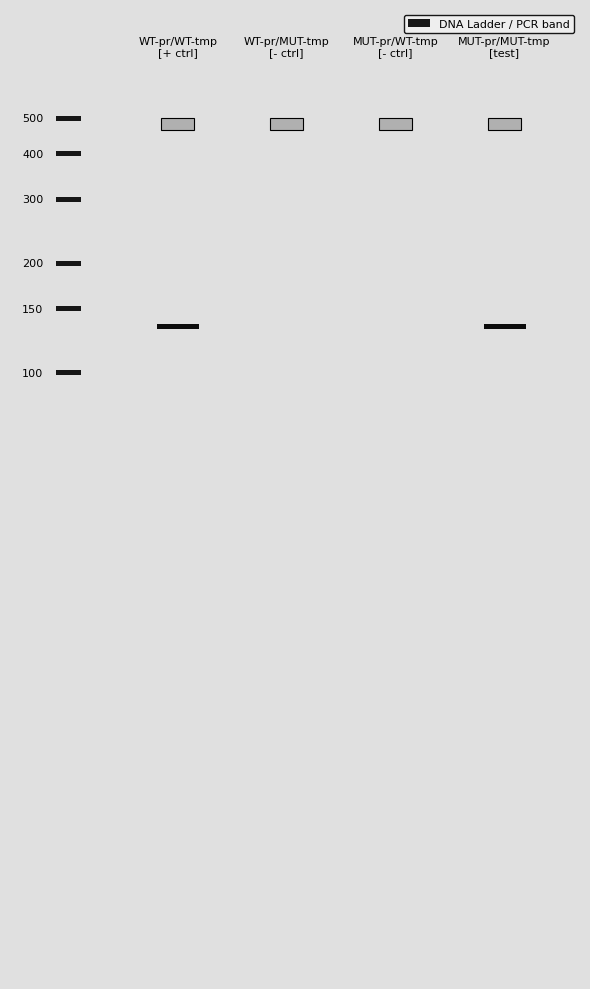

In [ ]:
lane_labels = [
    "WT-pr/WT-tmp\n[+ ctrl]",      # Lane 1: Positive control - should amplify
    "WT-pr/MUT-tmp\n[- ctrl]",     # Lane 2: Negative control - should NOT amplify
    "MUT-pr/WT-tmp\n[- ctrl]",     # Lane 3: Negative control - should NOT amplify
    "MUT-pr/MUT-tmp\n[test]"       # Lane 4: Test for mutation- should amplify
]

gel_results = PCRVisualization(
    primers=primers,
    wildtype_fasta_path=wildtype_fasta_path,
    mutant_fasta_path=mutant_fasta_path,
    mutation_name=mutation_name,
    output_directory=output_directory,
    lane_label_list=lane_labels,
)